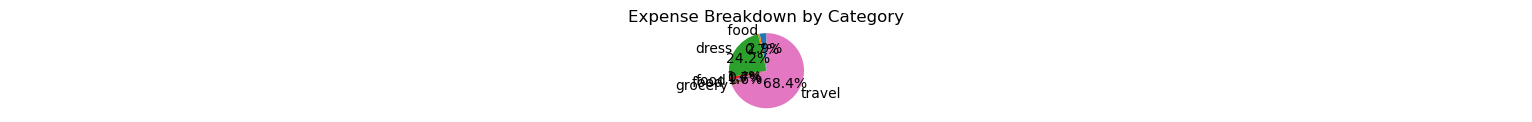

In [1]:
from tkinter import *
from tkinter.ttk import *
import sqlite3
import datetime
import random
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

LARGE_FONT = ("Verdana", 12)

class ExpenseTracker:
    def __init__(self, master):
        self.master = master
        self.master.title("Expense Tracker")
        self.master.geometry("800x600")
        self.create_database()
        self.categories = []  # Store user-defined categories
        self.main_window()
        self.create_goals_table()
 

    def create_database(self):
        conn = sqlite3.connect('data.db')
        with conn:
            conn.execute('''CREATE TABLE IF NOT EXISTS expenses (
                id INTEGER PRIMARY KEY,
                category TEXT,
                good TEXT,
                price INTEGER,
                date DATE
            );''')

    def insert_expense(self, category, good, price, date):
        conn = sqlite3.connect('data.db')
        with conn:
            conn.execute(
                "INSERT INTO expenses (category, good, price, date) VALUES (?, ?, ?, ?)",
                (category, good, price, date)
            )

    def display_expenses(self, category, text_widget):
        conn = sqlite3.connect('data.db')
        with conn:
            cursor = conn.cursor()
            cursor.execute(
                "SELECT * FROM expenses WHERE category = ?",
                (category,)
            )
            expenses = cursor.fetchall()
            text_widget.delete(1.0, END)
            for expense in expenses:
                text_widget.insert(END, f"Good: {expense[2]}, Price: {expense[3]}, Date: {expense[4]}\n")

    def delete_expense(self, category, good, price, date):
        conn = sqlite3.connect('data.db')
        with conn:
            cursor = conn.cursor()
            cursor.execute(
                "DELETE FROM expenses WHERE category = ? AND good = ? AND price = ? AND date = ?",
                (category, good, price, date)
            )

    def display_all_expenses(self, text_widget):
        conn = sqlite3.connect('data.db')
        with conn:
            cursor = conn.cursor()
            cursor.execute("SELECT * FROM expenses")
            expenses = cursor.fetchall()
            text_widget.delete(1.0, END)
            for expense in expenses:
                text_widget.insert(END, f"Category: {expense[1]}, Good: {expense[2]}, Price: {expense[3]}, Date: {expense[4]}\n")
    def create_goals_table(self):
        conn = sqlite3.connect('data.db')
        with conn:
            conn.execute('''CREATE TABLE IF NOT EXISTS goals (
                goal_id INTEGER PRIMARY KEY,
                category TEXT,
                target_amount INTEGER,
                current_amount INTEGER,
                deadline_date DATE
            );''')

    def insert_goal(self, category, target_amount, deadline_date):
        conn = sqlite3.connect('data.db')
        with conn:
            conn.execute(
                "INSERT INTO goals (category, target_amount, current_amount, deadline_date) VALUES (?, ?, ?, ?)",
                (category, target_amount, 0, deadline_date)
            )

    def display_goals(self, text_widget):
        conn = sqlite3.connect('data.db')
        with conn:
            cursor = conn.cursor()
            cursor.execute("SELECT * FROM goals")
            goals = cursor.fetchall()
            text_widget.delete(1.0, END)
            for goal in goals:
                text_widget.insert(END, f"Category: {goal[1]}, Target Amount: ${goal[2]}, Current Amount: ${goal[3]}, Deadline: {goal[4]}\n")

    def update_goal(self, goal_id, amount_saved):
        conn = sqlite3.connect('data.db')
        with conn:
            cursor = conn.cursor()
            cursor.execute("UPDATE goals SET current_amount = current_amount + ? WHERE goal_id = ?", (amount_saved, goal_id))

    def goals_tab(self):
        tab = self.tab3  # Create a new tab for goals

        category_label = Label(tab, text="Category")
        category_label.grid(row=0, column=0, sticky=W, pady=2)
        target_amount_label = Label(tab, text="Target Amount")
        target_amount_label.grid(row=1, column=0, sticky=W, pady=2)
        deadline_label = Label(tab, text="Deadline (dd-mm-yyyy)")
        deadline_label.grid(row=2, column=0, sticky=W, pady=2)

        category_entry = Entry(tab)
        category_entry.grid(row=0, column=1, sticky=W, pady=2)
        target_amount_entry = Entry(tab)
        target_amount_entry.grid(row=1, column=1, sticky=W, pady=2)
        deadline_entry = Entry(tab)
        deadline_entry.grid(row=2, column=1, sticky=W, pady=2)

        goal_text = Text(tab, width=60, height=10)
        goal_text.grid(row=3, column=0, columnspan=2, pady=10)

        # Create buttons for goals
        add_goal_button = Button(tab, text="Set Goal", command=lambda: self.insert_goal(
            category_entry.get(), int(target_amount_entry.get()), deadline_entry.get()))
        add_goal_button.grid(row=4, column=0)

        view_goals_button = Button(tab, text="View Goals", command=lambda: self.display_goals(goal_text))
        view_goals_button.grid(row=4, column=1)

        update_goal_label = Label(tab, text="Update Goal Progress")
        update_goal_label.grid(row=5, column=0, pady=10, columnspan=2)
        goal_id_label = Label(tab, text="Goalname")
        goal_id_label.grid(row=6, column=0, sticky=W)
        amount_saved_label = Label(tab, text="Amount Saved")
        amount_saved_label.grid(row=7, column=0, sticky=W)

        goal_id_entry = Entry(tab)
        goal_id_entry.grid(row=6, column=1, sticky=W)
        amount_saved_entry = Entry(tab)
        amount_saved_entry.grid(row=7, column=1, sticky=W)

        update_button = Button(tab, text="Update", command=lambda: self.update_goal(
            int(goal_id_entry.get()), int(amount_saved_entry.get())))
        update_button.grid(row=8, column=0, columnspan=2)

    def main_window(self):
        self.tabControl = Notebook(self.master)
        self.tab1 = Frame(self.tabControl)
        self.tab2 = Frame(self.tabControl)

        self.tabControl.add(self.tab1, text="Expense Tracker")
        self.tabControl.add(self.tab2, text="Expense Reduction Tips")

        self.tabControl.pack(expand=1, fill="both")

        self.expense_tab()
        self.tips_tab()
        self.tab3 = Frame(self.tabControl)
        self.tabControl.add(self.tab3, text="Financial Goals")
        self.goals_tab()


    def display_visualizations(self):
        conn = sqlite3.connect('data.db')
        with conn:
            cursor = conn.cursor()
            cursor.execute("SELECT category, SUM(price) FROM expenses GROUP BY category")
            data = cursor.fetchall()
            categories = [row[0] for row in data]
            total_prices = [row[1] for row in data]

        # Create a pie chart
        fig, ax = plt.subplots(figsize=(20,10))
        ax.pie(total_prices, labels=categories, autopct='%1.1f%%', startangle=90)
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        plt.title("Expense Breakdown by Category")
        plt.tight_layout()

        # Embed the pie chart in the Tkinter window
        chart_frame = Frame(self.master)
        chart_frame.pack(fill=BOTH, expand=True)
        chart = FigureCanvasTkAgg(fig, chart_frame)
        chart.get_tk_widget().pack(fill=BOTH, expand=True)
        
   
    def create_expense_entry(self, top, title):
        Label(top, text=title, font=LARGE_FONT).grid(row=0, column=0, pady=10, columnspan=2)
        Label(top, text="Category(food,dress,grocery...)").grid(row=1, column=0, sticky=W, pady=2)
        Label(top, text="Name of good").grid(row=2, column=0, sticky=W, pady=2)
        Label(top, text="Price").grid(row=3, column=0, sticky=W, pady=2)
        Label(top, text="Date of purchase (dd-mm-yyyy)").grid(row=4, column=0, sticky=W, pady=2)

        category_entry = Entry(top)
        category_entry.grid(row=1, column=1, sticky=W, pady=2)
        good_entry = Entry(top)
        good_entry.grid(row=2, column=1, sticky=W, pady=2)
        price_entry = Entry(top)
        price_entry.grid(row=3, column=1, sticky=W, pady=2)
        date_entry = Entry(top)
        date_entry.grid(row=4, column=1, sticky=W, pady=2)

        text = Text(top, width=50, height=10)
        text.grid(row=7, column=0, columnspan=2, pady=10)

        return category_entry, good_entry, price_entry, date_entry, text

    def create_buttons(self, top, insert_func, display_func, delete_func, top_text):
        B1 = Button(top, text="Insert Expense", command=lambda: insert_func())
        B1.grid(row=5, column=0)

        B2 = Button(top, text="Display Expenses", command=lambda: display_func())
        B2.grid(row=5, column=1)

        B3 = Button(top, text="Delete Expense", command=lambda: delete_func())
        B3.grid(row=6, column=0)

        B4 = Button(top, text="Show All Expenses", command=lambda: self.display_all_expenses(top_text))
        B4.grid(row=6, column=1)

        B5 = Button(top, text="Data Visualization", command=lambda: self.display_visualizations())
        B5.grid(row=9, column=2, columnspan=2)

    def expense_tab(self):
        tab = self.tab1

        category_entry, good_entry, price_entry, date_entry, text = self.create_expense_entry(tab, 'Expense Tracker')

        self.create_buttons(tab,
            lambda: self.insert_expense(category_entry.get(), good_entry.get(), price_entry.get(), date_entry.get()),
            lambda: self.display_expenses(category_entry.get(), text),
            lambda: self.delete_expense(category_entry.get(), good_entry.get(), price_entry.get(), date_entry.get()),
            text  # Pass text widget for Show All Expenses
        )

        top_text = Text(tab, width=60, height=10)
        top_text.grid(row=8, column=0, columnspan=2, pady=10)

        # Add Category Management
        Label(tab, text="Manage Categories").grid(row=9, column=0, pady=10, columnspan=2)
        category_label = Label(tab, text="New Category")
        category_label.grid(row=10, column=0, sticky=W)
        category_entry = Entry(tab)
        category_entry.grid(row=10, column=1, sticky=W)
        add_category_button = Button(tab, text="Add Category", command=lambda: self.create_category(category_entry.get()))
        add_category_button.grid(row=10, column=2, sticky=W)

        # Add Expense History
        Label(tab, text="View Expense History").grid(row=11, column=0, pady=10, columnspan=2)
        period_label = Label(tab, text="Enter year")
        period_label.grid(row=12, column=0, sticky=W)
        period_entry = Entry(tab)
        period_entry.grid(row=12, column=1, sticky=W)
        view_history_button = Button(tab, text="View History", command=lambda: self.view_expense_history(period_entry.get(), top_text))
        view_history_button.grid(row=12, column=2, sticky=W)

    def create_category(self, category):
        if category not in self.categories:
            self.categories.append(category)

    def view_expense_history(self, period, text_widget):
        conn = sqlite3.connect('data.db')
        with conn:
            cursor = conn.cursor()
            cursor.execute(
                "SELECT * FROM expenses WHERE date >= ?",
                (period,)
            )
            expenses = cursor.fetchall()
            text_widget.delete(1.0, END)
            for expense in expenses:
                text_widget.insert(END, f"Category: {expense[1]}, Good: {expense[2]}, Price: {expense[3]}, Date: {expense[4]}\n")

    def tips_tab(self):
        tab = self.tab2

        tips_text = Text(tab, width=60, height=20)
        tips_text.grid(row=0, column=0, padx=20, pady=20)

        tip_button = Button(tab, text="Get Expense Reduction Tips", command=lambda: self.display_tips(tips_text))
        tip_button.grid(row=1, column=0, pady=10)

    def display_tips(self, text_widget):
        tips = [
            "purchase based  on which is need or not  now.",
            "Create a budget and stick to it.",
            " go shop which provided discounts.",
            " before purchase , think it is need or not now .",
            " set limitation  of products purchasing .",
            "Shop for sales and use coupons when  shopping.",
            "Limit impulse purchases.",
            "Track your expenses to identify areas where you can save.",
        ]

        random_tip = random.choice(tips)
        text_widget.delete(1.0, END)
        text_widget.insert(END, "Expense Reduction Tip:\n\n")
        text_widget.insert(END, random_tip)

def main():
    root = Tk()
    app = ExpenseTracker(root)
    root.mainloop()

if __name__ == "__main__":
    main()